<h1 style="color:indigo">*Entrenamiento para clasificar cobertura del suelo utilizando Spark</h1>
<p>Autor: <a href="https://www.linkedin.com/in/albertoav" style="text-decoration:none;">Alberto Álvarez Vales</a>     
</p>
Fecha: 22/03/2019


In [1]:
from geopandas import read_file,GeoDataFrame

In [2]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.sql import SQLContext
spark = SQLContext(sc)

In [3]:
datosGlobales=read_file("segmented_TopFixed.gpkg")
datosEntrenamiento=read_file("ForClassifySegments.gpkg")

In [4]:
dfGlobal=spark.createDataFrame(datosGlobales)
dfEntrenamiento=spark.createDataFrame(datosEntrenamiento)

In [5]:
dfGlobal.show(2)

+---+------+---------+--------------+--------+-----------+------------------+---------+------------------+------+------+------------------+--------+------------------+---------+------------------+------+------+------------------+---------+------------------+---------+------------------+------+------+------------------+--------------------+
|cat|  area|perimeter|compact_circle|      fd|     B1_sum|           B1_mean|B1_median|          B1_stdev|B1_min|B1_max|       B1_variance|  B2_sum|           B2_mean|B2_median|          B2_stdev|B2_min|B2_max|       B2_variance|   B3_sum|           B3_mean|B3_median|          B3_stdev|B3_min|B3_max|       B3_variance|            geometry|
+---+------+---------+--------------+--------+-----------+------------------+---------+------------------+------+------+------------------+--------+------------------+---------+------------------+------+------+------------------+---------+------------------+---------+------------------+------+------+---------------

In [6]:
dfEntrenamiento.show(2)

+------+----+------+---------+----------+--------+----+--------------------+
|Source| cat|  area|perimeter|compact_ci|      fd|tipo|            geometry|
+------+----+------+---------+----------+--------+----+--------------------+
| INPUT| 303| 861.0|    244.0|  2.345759|1.626839|   5|[94649983183656, ...|
| INPUT|1968|1350.0|    352.0|  2.702532| 1.62701|   5|[94649949367768, ...|
+------+----+------+---------+----------+--------+----+--------------------+
only showing top 2 rows



In [7]:
dfE=dfEntrenamiento.select("cat","tipo").join(dfGlobal,"cat","inner")

In [8]:
dfE.show(2)

+-----+----+-------+---------+--------------+--------+-----------+-----------------+---------+------------------+------+------+------------------+-----------+------------------+---------+------------------+------+------+----------------+-----------+-----------------+---------+------------------+------+------+------------------+--------------------+
|  cat|tipo|   area|perimeter|compact_circle|      fd|     B1_sum|          B1_mean|B1_median|          B1_stdev|B1_min|B1_max|       B1_variance|     B2_sum|           B2_mean|B2_median|          B2_stdev|B2_min|B2_max|     B2_variance|     B3_sum|          B3_mean|B3_median|          B3_stdev|B3_min|B3_max|       B3_variance|            geometry|
+-----+----+-------+---------+--------------+--------+-----------+-----------------+---------+------------------+------+------+------------------+-----------+------------------+---------+------------------+------+------+----------------+-----------+-----------------+---------+------------------+--

In [9]:
from pyspark.ml.feature import VectorAssembler

In [10]:
columnas=['area', 'perimeter',  'fd', 'perimeter', 'compact_circle', 'fd', 'B1_sum', 'B1_mean', 'B1_median', 'B1_stdev', 'B1_min', 'B1_max', 'B1_variance', 'B2_sum', 'B2_mean', 'B2_median', 'B2_stdev', 'B2_min', 'B2_max', 'B2_variance', 'B3_sum', 'B3_mean', 'B3_median', 'B3_stdev', 'B3_min', 'B3_max', 'B3_variance']
constructor=VectorAssembler(inputCols=columnas,
                            outputCol="features")

In [11]:
dfEF=constructor.transform(dfE).select("cat","features","tipo")

In [12]:
entrena,evalua=dfEF.randomSplit([0.8,0.2])

In [13]:
from pyspark.ml.classification import RandomForestClassifier # este algoritmo es el que ofreció mejores resultados en las pruebas
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [14]:
rf=RandomForestClassifier(labelCol="tipo")

In [15]:
modelo=rf.fit(entrena)

In [16]:
pred=modelo.transform(evalua)

In [17]:
pred.crosstab("tipo","prediction").orderBy("tipo_prediction").show()

+---------------+---+---+---+---+---+---+---+
|tipo_prediction|1.0|2.0|3.0|4.0|5.0|6.0|7.0|
+---------------+---+---+---+---+---+---+---+
|              1|  8|  0|  3|  0|  0|  0|  0|
|              2|  0|  3|  0|  0|  0|  0|  0|
|              3|  1|  1| 10|  0|  0|  1|  0|
|              4|  0|  0|  1|  4|  0|  0|  0|
|              5|  0|  0|  0|  0|  6|  0|  0|
|              6|  1|  1|  0|  0|  0| 13|  0|
|              7|  0|  1|  0|  0|  0|  3|  5|
+---------------+---+---+---+---+---+---+---+



In [18]:
evaluador=MulticlassClassificationEvaluator(labelCol="tipo",metricName="accuracy")

In [19]:
evaluador.evaluate(pred)

0.7903225806451613

In [20]:
modeloOk=rf.fit(dfEF)

In [21]:
modeloOk.write().overwrite().save("modelorf") #eliminar overwrite() si no se quiere sobreescribir el modelo

# Script de Python para subir a GitLab:

In [22]:
from geopandas import read_file,GeoDataFrame
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier # este algoritmo es el que ofreció mejores resultados en las pruebas
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

sc = SparkContext.getOrCreate()
spark = SQLContext(sc)

datosGlobales=read_file("segmented_TopFixed.gpkg")
datosEntrenamiento=read_file("ForClassifySegments.gpkg")

dfGlobal=spark.createDataFrame(datosGlobales)
dfEntrenamiento=spark.createDataFrame(datosEntrenamiento)
dfE=dfEntrenamiento.select("cat","tipo").join(dfGlobal,"cat","inner")

columnas=['area', 'perimeter',  'fd', 'perimeter', 'compact_circle', 'fd', 'B1_sum', 'B1_mean', 'B1_median', 'B1_stdev', 'B1_min', 'B1_max', 'B1_variance', 'B2_sum', 'B2_mean', 'B2_median', 'B2_stdev', 'B2_min', 'B2_max', 'B2_variance', 'B3_sum', 'B3_mean', 'B3_median', 'B3_stdev', 'B3_min', 'B3_max', 'B3_variance']
constructor=VectorAssembler(inputCols=columnas,outputCol="features")

dfEF=constructor.transform(dfE).select("cat","features","tipo")

entrena,evalua=dfEF.randomSplit([0.8,0.2])

rf=RandomForestClassifier(labelCol="tipo")

modelo=rf.fit(entrena)

pred=modelo.transform(evalua)

evaluador=MulticlassClassificationEvaluator(labelCol="tipo",metricName="accuracy")

metrica=evaluador.evaluate(pred)

if metrica>=0.75:
    modeloOk=rf.fit(dfEF)
    print("Se guarda el modelo a disco (métrica: ",metrica,")")
    modeloOk.write().overwrite().save("modelorf") #eliminar overwrite() si no se quiere sobreescribir el modelo
else:
    print("El modelo no es lo bastante bueno, métrica: ",metrica)

El modelo no es lo bastante bueno, métrica:  0.7454545454545455


# Paralelización


In [23]:
from geopandas import read_file,GeoDataFrame
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier # este algoritmo es el que ofreció mejores resultados en las pruebas
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#conf = (SparkConf().setAppName("implicit_benchmark").setMaster('local[*]').set('spark.driver.memory', '16G'))
conf = (SparkConf().setAppName("implicit_benchmark").setMaster('local[*]'))

In [25]:
%%timeit -n 1
conf = (SparkConf().setAppName("implicit_benchmark").setMaster('local[1]'))
sc = SparkContext.getOrCreate(conf=conf)
spark = SQLContext(sc)

datosGlobales=read_file("segmented_TopFixed.gpkg")
datosEntrenamiento=read_file("ForClassifySegments.gpkg")

dfGlobal=spark.createDataFrame(datosGlobales)
dfEntrenamiento=spark.createDataFrame(datosEntrenamiento)
dfE=dfEntrenamiento.select("cat","tipo").join(dfGlobal,"cat","inner")

columnas=['area', 'perimeter',  'fd', 'perimeter', 'compact_circle', 'fd', 'B1_sum', 'B1_mean', 'B1_median', 'B1_stdev', 'B1_min', 'B1_max', 'B1_variance', 'B2_sum', 'B2_mean', 'B2_median', 'B2_stdev', 'B2_min', 'B2_max', 'B2_variance', 'B3_sum', 'B3_mean', 'B3_median', 'B3_stdev', 'B3_min', 'B3_max', 'B3_variance']
constructor=VectorAssembler(inputCols=columnas,outputCol="features")

dfEF=constructor.transform(dfE).select("cat","features","tipo")

entrena,evalua=dfEF.randomSplit([0.8,0.2])

rf=RandomForestClassifier(labelCol="tipo")

modelo=rf.fit(entrena)

pred=modelo.transform(evalua)

evaluador=MulticlassClassificationEvaluator(labelCol="tipo",metricName="accuracy")

metrica=evaluador.evaluate(pred)

if metrica>=0.75:
    modeloOk=rf.fit(dfEF)
    print("Se guarda el modelo a disco (métrica: ",metrica,")")
    modeloOk.write().overwrite().save("modelorf") #eliminar overwrite() si no se quiere sobreescribir el modelo
else:
    print("El modelo no es lo bastante bueno, métrica: ",metrica)

Se guarda el modelo a disco (métrica:  0.8095238095238095 )
Se guarda el modelo a disco (métrica:  0.75 )
El modelo no es lo bastante bueno, métrica:  0.7272727272727273
Se guarda el modelo a disco (métrica:  0.8518518518518519 )
Se guarda el modelo a disco (métrica:  0.84 )
Se guarda el modelo a disco (métrica:  0.76 )
Se guarda el modelo a disco (métrica:  0.9444444444444444 )
13.5 s ± 1.46 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%timeit -n 1
conf = (SparkConf().setAppName("implicit_benchmark").setMaster('local[2]'))
sc = SparkContext.getOrCreate(conf=conf)
spark = SQLContext(sc)

datosGlobales=read_file("segmented_TopFixed.gpkg")
datosEntrenamiento=read_file("ForClassifySegments.gpkg")

dfGlobal=spark.createDataFrame(datosGlobales)
dfEntrenamiento=spark.createDataFrame(datosEntrenamiento)
dfE=dfEntrenamiento.select("cat","tipo").join(dfGlobal,"cat","inner")

columnas=['area', 'perimeter',  'fd', 'perimeter', 'compact_circle', 'fd', 'B1_sum', 'B1_mean', 'B1_median', 'B1_stdev', 'B1_min', 'B1_max', 'B1_variance', 'B2_sum', 'B2_mean', 'B2_median', 'B2_stdev', 'B2_min', 'B2_max', 'B2_variance', 'B3_sum', 'B3_mean', 'B3_median', 'B3_stdev', 'B3_min', 'B3_max', 'B3_variance']
constructor=VectorAssembler(inputCols=columnas,outputCol="features")

dfEF=constructor.transform(dfE).select("cat","features","tipo")

entrena,evalua=dfEF.randomSplit([0.8,0.2])

rf=RandomForestClassifier(labelCol="tipo")

modelo=rf.fit(entrena)

pred=modelo.transform(evalua)

evaluador=MulticlassClassificationEvaluator(labelCol="tipo",metricName="accuracy")

metrica=evaluador.evaluate(pred)

if metrica>=0.75:
    modeloOk=rf.fit(dfEF)
    print("Se guarda el modelo a disco (métrica: ",metrica,")")
    modeloOk.write().overwrite().save("modelorf") #eliminar overwrite() si no se quiere sobreescribir el modelo
else:
    print("El modelo no es lo bastante bueno, métrica: ",metrica)

Se guarda el modelo a disco (métrica:  0.8333333333333334 )
El modelo no es lo bastante bueno, métrica:  0.7368421052631579
Se guarda el modelo a disco (métrica:  0.8125 )
Se guarda el modelo a disco (métrica:  0.8125 )
Se guarda el modelo a disco (métrica:  0.8095238095238095 )
El modelo no es lo bastante bueno, métrica:  0.7368421052631579
El modelo no es lo bastante bueno, métrica:  0.65
12.1 s ± 1.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit -n 1
conf = (SparkConf().setAppName("implicit_benchmark").setMaster('local[4]'))
sc = SparkContext.getOrCreate(conf=conf)
spark = SQLContext(sc)

datosGlobales=read_file("segmented_TopFixed.gpkg")
datosEntrenamiento=read_file("ForClassifySegments.gpkg")

dfGlobal=spark.createDataFrame(datosGlobales)
dfEntrenamiento=spark.createDataFrame(datosEntrenamiento)
dfE=dfEntrenamiento.select("cat","tipo").join(dfGlobal,"cat","inner")

columnas=['area', 'perimeter',  'fd', 'perimeter', 'compact_circle', 'fd', 'B1_sum', 'B1_mean', 'B1_median', 'B1_stdev', 'B1_min', 'B1_max', 'B1_variance', 'B2_sum', 'B2_mean', 'B2_median', 'B2_stdev', 'B2_min', 'B2_max', 'B2_variance', 'B3_sum', 'B3_mean', 'B3_median', 'B3_stdev', 'B3_min', 'B3_max', 'B3_variance']
constructor=VectorAssembler(inputCols=columnas,outputCol="features")

dfEF=constructor.transform(dfE).select("cat","features","tipo")

entrena,evalua=dfEF.randomSplit([0.8,0.2])

rf=RandomForestClassifier(labelCol="tipo")

modelo=rf.fit(entrena)

pred=modelo.transform(evalua)

evaluador=MulticlassClassificationEvaluator(labelCol="tipo",metricName="accuracy")

metrica=evaluador.evaluate(pred)

if metrica>=0.75:
    modeloOk=rf.fit(dfEF)
    print("Se guarda el modelo a disco (métrica: ",metrica,")")
    modeloOk.write().overwrite().save("modelorf") #eliminar overwrite() si no se quiere sobreescribir el modelo
else:
    print("El modelo no es lo bastante bueno, métrica: ",metrica)

El modelo no es lo bastante bueno, métrica:  0.65
Se guarda el modelo a disco (métrica:  0.8095238095238095 )
Se guarda el modelo a disco (métrica:  0.8260869565217391 )
Se guarda el modelo a disco (métrica:  0.76 )
Se guarda el modelo a disco (métrica:  0.8695652173913043 )
Se guarda el modelo a disco (métrica:  0.8148148148148148 )
Se guarda el modelo a disco (métrica:  0.8823529411764706 )
14.3 s ± 1.85 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit -n 1
conf = (SparkConf().setAppName("implicit_benchmark").setMaster('local[6]'))
sc = SparkContext.getOrCreate(conf=conf)
spark = SQLContext(sc)

datosGlobales=read_file("segmented_TopFixed.gpkg")
datosEntrenamiento=read_file("ForClassifySegments.gpkg")

dfGlobal=spark.createDataFrame(datosGlobales)
dfEntrenamiento=spark.createDataFrame(datosEntrenamiento)
dfE=dfEntrenamiento.select("cat","tipo").join(dfGlobal,"cat","inner")

columnas=['area', 'perimeter',  'fd', 'perimeter', 'compact_circle', 'fd', 'B1_sum', 'B1_mean', 'B1_median', 'B1_stdev', 'B1_min', 'B1_max', 'B1_variance', 'B2_sum', 'B2_mean', 'B2_median', 'B2_stdev', 'B2_min', 'B2_max', 'B2_variance', 'B3_sum', 'B3_mean', 'B3_median', 'B3_stdev', 'B3_min', 'B3_max', 'B3_variance']
constructor=VectorAssembler(inputCols=columnas,outputCol="features")

dfEF=constructor.transform(dfE).select("cat","features","tipo")

entrena,evalua=dfEF.randomSplit([0.8,0.2])

rf=RandomForestClassifier(labelCol="tipo")

modelo=rf.fit(entrena)

pred=modelo.transform(evalua)

evaluador=MulticlassClassificationEvaluator(labelCol="tipo",metricName="accuracy")

metrica=evaluador.evaluate(pred)

if metrica>=0.75:
    modeloOk=rf.fit(dfEF)
    print("Se guarda el modelo a disco (métrica: ",metrica,")")
    modeloOk.write().overwrite().save("modelorf") #eliminar overwrite() si no se quiere sobreescribir el modelo
else:
    print("El modelo no es lo bastante bueno, métrica: ",metrica)

El modelo no es lo bastante bueno, métrica:  0.7368421052631579
Se guarda el modelo a disco (métrica:  0.8 )
Se guarda el modelo a disco (métrica:  0.8888888888888888 )
Se guarda el modelo a disco (métrica:  0.8260869565217391 )
Se guarda el modelo a disco (métrica:  0.8148148148148148 )
Se guarda el modelo a disco (métrica:  0.8571428571428571 )
El modelo no es lo bastante bueno, métrica:  0.6956521739130435
13.3 s ± 1.79 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
conf = (SparkConf().setAppName("implicit_benchmark").setMaster('local[6]'))
sc = SparkContext.getOrCreate(conf=conf)
spark = SQLContext(sc)

datosGlobales=read_file("segmented_TopFixed.gpkg")
datosEntrenamiento=read_file("ForClassifySegments.gpkg")

dfGlobal=spark.createDataFrame(datosGlobales)
dfEntrenamiento=spark.createDataFrame(datosEntrenamiento)
dfE=dfEntrenamiento.select("cat","tipo").join(dfGlobal,"cat","inner")

columnas=['area', 'perimeter',  'fd', 'perimeter', 'compact_circle', 'fd', 'B1_sum', 'B1_mean', 'B1_median', 'B1_stdev', 'B1_min', 'B1_max', 'B1_variance', 'B2_sum', 'B2_mean', 'B2_median', 'B2_stdev', 'B2_min', 'B2_max', 'B2_variance', 'B3_sum', 'B3_mean', 'B3_median', 'B3_stdev', 'B3_min', 'B3_max', 'B3_variance']
constructor=VectorAssembler(inputCols=columnas,outputCol="features")

dfEF=constructor.transform(dfE).select("cat","features","tipo")

entrena,evalua=dfEF.randomSplit([0.8,0.2])

rf=RandomForestClassifier(labelCol="tipo")

entrena.cache()
evalua.cache()


DataFrame[cat: bigint, features: vector, tipo: bigint]

In [30]:
%%timeit -n 1
modelo=rf.fit(entrena)
pred=modelo.transform(evalua)
metrica=evaluador.evaluate(pred)

4.03 s ± 352 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<a href="mailto:alberto@torredebabel.com" style="text-decoration:none;" title="Alberto Álvarez Vales">
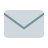</a>
<a href="https://www.linkedin.com/in/albertoav" style="text-decoration:none;" title="Alberto Álvarez Vales">
</a> 